# Mutation-selection models in phylogenetics

These notes describe a codon-based model of sequence evolution which explicitly model mutation and selection. Substitutions in such a sequence will evolve according to a mutational model (JC69 at the moment, but easily changed) and a selection model (Wright-Fisher, independent sites). These define a rate matrix $Q$ whose $I,J$ entry is given by
$$ Q_{IJ} = \mu_{IJ} \frac{p(N,s_{IJ})}{p(N,0)}. $$
Here $I$ and $J$ index the 61 sense codons. $\mu_{IJ}$ denotes the mutation rate of codon $I=[i_1, i_2, i_3]$ into codon $J=[j_1, j_2, j_3]$, and is given by
$$ \mu_{IJ} = \mu_{i_1 j_1} \mu_{i_2 j_2} \mu_{i_3 j_3}, $$
where $u_{ij}$ are the mutation rates of the nucleotide $i$ into $j$. Selection coefficients are given by
$$ s_{IJ} = \frac{f_J}{f_I}-1, $$
where $f_I$ denotes the Darwinian fitness of codon $I$. Finally, $p(N,s)$ denotes Kimura's probability of fixation for the Wright-Fisher process, which for a Haploid population is given and approximated by
$$ p(N,s) = \frac{1-e^{-2s}}{1-e^{-2Ns}} \approx \frac{2s}{1-e^{-2Ns}}, \mbox{ and } p(N,0) = 1/N. $$
For the moment we assume $N$ and all $\mu_{ij}$ to be known. We are primarily concerned with protein evolution, and while we do not deny that codon bias is important, the only unknown parameters in our models will be 20 fitnesses for each amino acid. Let $\mathbb{C}$ denote the set of codons, and $\mathbb{A}$ the set of amino acids. Let $ \mathcal{A}:\mathbb{C} \rightarrow \mathbb{A} $ denote the translation operator, converting codons into amino acids according to the genetic code. The fitness of codon $I$ is then $ f_I = f_{\mathcal{A}(I)} $. Using the Malthusian fitness $f'_I = \log(f_I)$ and the Taylor expansion
$$ \log(1+x) = 1+x+\mathcal{O}(x^2),$$
one can show
$$ s_{IJ} \approx f'_J - f'_I. $$
Denoting the scaled Malthusian fitness by $ F'_I = 2N f'_I $, a modest calculation shows that
$$ q_{IJ} \approx \mu_{IJ} \frac{F'_J-F'_I}{e^{F'_J}-e^{F'_I}} e^{F'_J} $$
so that $ Q $ has the form $ Q = Q_S Q_\pi $, where $ Q_S = Q_S^T $ and $ Q_{\pi} = $ $\text{diag}( e^{F'_{C_1}}, \dots, e^{F'_{C_{61}}} ). $ This is the required structure for a reversible Markov Chain, and hence the equilibrium frequencies of codon $I$ is $ \pi_{I} = e^{F'_I} $. Following Yang and Nielsen, we parameterize the model in terms of these 20 equilibrium frequencies (there are 20 since they are uniquely determined by fitness and there are only 20 amino acid fitnesses). As such, they should satisfy
$$ \sum_{C \in \mathbb{C}} \pi_c = 1. $$
Since scaling the Darwinian fitnesses by a factor $\alpha$ does not affect the selective coefficients, given the fitnesses we can choose $\alpha$ such that the above equation holds. Upon calculating
$$ \pi_C = e^{F'_C} = e^{2N\log(\alpha f_c)} = \alpha^{2N} f_c^{2N},$$
plugging into the previous equation and solving for $\alpha$ gives
$$ \alpha = \left( \sum_{C \in \mathbb{C}} f_C^{2N}\right)^{-1/2N} = \left( \sum_{A \in \mathbb{A}} d_A f_A^{2N}\right)^{-1/2N}, $$
where $d_A$ is the degeneracy of amino acid $A$ according to the genetic code. The sum is written in terms of these parameters to avoid redundancy.

Thus we may specify Darwinian fitnesses to generate the data, while we estimate equilibrium frequencies when estimating parameters. In terms of this parameterization, the rate matrix is now
$$ q_{IJ} = \mu_{IJ} \frac{\log(\frac{\pi_J}{\pi_I})}{1-\frac{\pi_I}{\pi_J}}. $$
A given vector of equilibrium frequencies gives a $Q$ matrix, which is used to compute a likelihood via Felsenstein's pruning algorithm. When optimizing over all possible equilibrium frequencies we add the constraints
$$ 0 \le \pi_A \le 1 \mbox{ for all } A \in \mathbb{A} \mbox{ and } \sum_{A \in \mathbb{A}} d_A \pi_{A} = 1.$$

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from random import seed
from itertools import product
from Bio.Seq import Seq
from scipy.optimize import minimize
from data import *
from phylo import *
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
random_seed = 1
np.random.seed(random_seed)
seed(random_seed)

In [3]:
indices_string = ''.join(['%2d ' % i for i in range(20)])
amino_acids_string = ''.join(['%2s ' % a for a in amino_acids])
print(indices_string+'\n'+amino_acids_string)

 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 
 A  C  D  E  F  G  H  I  K  L  M  N  P  Q  R  S  T  V  W  Y 


In [4]:
translate = lambda codon: str(Seq(codon).translate())
codon_index_for_amino_acid_index = np.zeros(61, dtype=np.int)
for i, codon in enumerate(codons):
    amino_acid = translate(codon)
    amino_acid_index = amino_acids.tolist().index(amino_acid)
    codon_index_for_amino_acid_index[i] = amino_acid_index
    print('%2d) %s -> %s :%2d   ' % (i, codon, amino_acid, amino_acid_index), end='')
    if (i+1) % 6 == 0:
        print('')

 0) AAA -> K : 8    1) AAG -> K : 8    2) AAC -> N :11    3) AAT -> N :11    4) AGA -> R :14    5) AGG -> R :14   
 6) AGC -> S :15    7) AGT -> S :15    8) ACA -> T :16    9) ACG -> T :16   10) ACC -> T :16   11) ACT -> T :16   
12) ATA -> I : 7   13) ATG -> M :10   14) ATC -> I : 7   15) ATT -> I : 7   16) GAA -> E : 3   17) GAG -> E : 3   
18) GAC -> D : 2   19) GAT -> D : 2   20) GGA -> G : 5   21) GGG -> G : 5   22) GGC -> G : 5   23) GGT -> G : 5   
24) GCA -> A : 0   25) GCG -> A : 0   26) GCC -> A : 0   27) GCT -> A : 0   28) GTA -> V :17   29) GTG -> V :17   
30) GTC -> V :17   31) GTT -> V :17   32) CAA -> Q :13   33) CAG -> Q :13   34) CAC -> H : 6   35) CAT -> H : 6   
36) CGA -> R :14   37) CGG -> R :14   38) CGC -> R :14   39) CGT -> R :14   40) CCA -> P :12   41) CCG -> P :12   
42) CCC -> P :12   43) CCT -> P :12   44) CTA -> L : 9   45) CTG -> L : 9   46) CTC -> L : 9   47) CTT -> L : 9   
48) TAC -> Y :19   49) TAT -> Y :19   50) TGG -> W :18   51) TGC -> C : 1   52) 

In [5]:
degeneracy = np.zeros(20, dtype=np.int)
for codon in codons:
    amino_acid = translate(codon)
    amino_acid_index = amino_acids.tolist().index(amino_acid)
    degeneracy[amino_acid_index] += 1

In [6]:
N = 10000
mu = 1e-8
fitnesses = np.linspace(1, 1+1/N, 20)
mean_of_fitnesses = np.mean(fitnesses)
fitnesses /= mean_of_fitnesses
products = degeneracy*fitnesses**(2*N)
alpha = np.sum(products)**(-1/(2*N))
frequencies = (alpha*fitnesses)**(2*N)
# JC69 matrix
Qmu = jc69(mu)

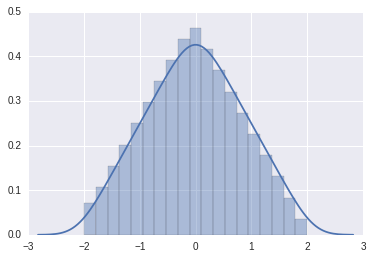

In [7]:
fvec = fitnesses.reshape(-1,1)
Smat = np.dot(fvec, 1/fvec.T)-1.
S = 2*N*Smat.flatten()
sns.distplot(S, bins=19)
plt.show()

In [8]:
nucleotide_to_index = {'A':0, 'G':1, 'C':2, 'T':3}
codon_frequencies = frequencies[codon_index_for_amino_acid_index]
def Qmutsel(frequencies):
    Q = np.zeros((61, 61))
    # Upper case letters index codons, lower case index amino acids
    for I, codon_I in enumerate(codons):
        i = codon_index_for_amino_acid_index[I]
        for J, codon_J in enumerate(codons):
            j = codon_index_for_amino_acid_index[J]
            # Selection
            if I != J:
                current_absolute_error = np.abs(frequencies[i]-frequencies[j])
                if current_absolute_error < 1e-12:
                    Q[I, J] = 1
                else:
                    numerator = np.log(frequencies[j]/frequencies[i])
                    denominator = (1-frequencies[i]/frequencies[j])
                    Q[I, J] = numerator/denominator
            # Mutation
            for k in range(3):
                nucleotide_i = codon_I[k]
                nucleotide_j = codon_J[k]
                if nucleotide_i != nucleotide_j:
                    i_n = nucleotide_to_index[nucleotide_i]
                    j_n = nucleotide_to_index[nucleotide_j]
                    Q[I, J] *= Qmu[i_n, j_n]
        Q[I, I] = -np.sum(Q[I,:])
    beta = np.sum(codon_frequencies*np.diag(Q))
    Q /= beta
    return Q

In [9]:
Q = Qmutsel(frequencies)
sequence_length = 400
sequence = random_sequence(sequence_length, codon_frequencies)
extant_taxa = 200
tree = phylogenetic_tree(extant_taxa)
data = generate_data(sequence, Q, tree)

In [10]:
pi0 = np.ones(20)
pi0 /= np.dot(pi0, degeneracy)
bounds = 20*((1e-12, 1), )
sumtoone = lambda pi: np.dot(pi, degeneracy)-1
constraints = {'type':'eq', 'fun':sumtoone}
def negative_likelihood(pi):
    Q = Qmutsel(pi)
    return -prune(data, tree, Q, pi[codon_index_for_amino_acid_index])
result = minimize(negative_likelihood, pi0, bounds=bounds, constraints=constraints, tol=1e-3)

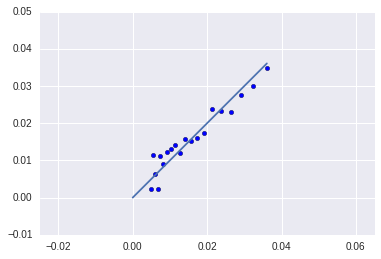

In [11]:
freq_max = np.max(frequencies)
plt.scatter(frequencies, result.x)
plt.plot([0, freq_max], [0, freq_max])
plt.axis('equal')
plt.show()

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

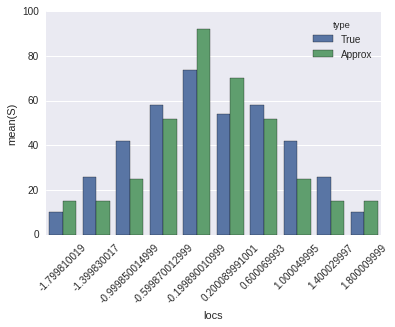

In [12]:
approx_fvec = (result.x**(1/(2*N))/alpha).reshape(-1, 1)
approx_Smat =  np.dot(approx_fvec, 1/approx_fvec.T)-1.
approx_S = 2*N*approx_Smat.flatten()
n_bins = 10
S_counts, S_bins = np.histogram(S, bins=n_bins)
bin_locs = list(.5*(S_bins[1:]+S_bins[:-1]))
approx_S_counts, _ = np.histogram(approx_S, bins=S_bins)
plot_df = pd.DataFrame({
        'locs': 2*bin_locs,
        'S': np.hstack([S_counts, approx_S_counts]),
        'type': n_bins*['True']+n_bins*['Approx']
    })
ax = sns.barplot(x='locs', y='S', data=plot_df, hue='type')
plt.xticks(rotation=45)